# Lab | Random Forests

### Importing the datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold 

pd.set_option('display.max_columns', None)

In [2]:
numerical=pd.read_csv('./files_for_lab/numerical.csv')
categorical=pd.read_pickle('./files_for_lab/categorical.pkl')
targets=pd.read_csv('./files_for_lab/target.csv')

In [3]:
#many columns in the categorical are still int or float so need to convert them
categorical=categorical.astype(str)

In [4]:
categorical

,STATE,CLUSTER,AGEFLAG,HOMEOWNR,GENDER,DATASRCE,SOLIH,VETERANS,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B
0,IL,36,U,U,F,0,4,N,L,E,C,T,2
1,CA,14,E,H,M,3,4,N,L,G,A,S,1
2,NC,43,U,U,M,3,4,N,L,E,C,R,2
3,CA,44,E,U,F,3,4,N,L,E,C,R,2
4,FL,16,E,H,F,3,12,N,L,F,A,S,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,other,27,U,U,M,0,4,N,L,G,C,C,2
95408,TX,24,E,H,M,3,4,N,L,F,A,C,1
95409,MI,30,U,U,M,0,4,N,L,E,B,C,3
95410,CA,24,E,H,F,2,12,N,L,F,A,C,1


In [5]:
all_data= pd.concat([numerical, categorical, targets], axis = 1)

In [6]:
all_data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [7]:
all_data.shape

(95412, 330)

In [8]:
all_data.isna().sum().sum() #no nans in the data

0

## Classification

### Model 1- Without any feature selection

#### X,y split and Train-Test Split

In [9]:
y_class= all_data['TARGET_B'] #target for classification
X= all_data.drop(['TARGET_B','TARGET_D'],axis=1) #TARGET_D will be used for regression

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=0)

X_train_num   = X_train.select_dtypes(np.number)
X_test_num    = X_test.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object) 
X_test_cat  = X_test.select_dtypes(object) 

In [11]:
X_train_cat

,STATE,CLUSTER,AGEFLAG,HOMEOWNR,GENDER,DATASRCE,SOLIH,VETERANS,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B
79401,other,24,E,H,M,3,4,N,L,D,B,C,1
86429,other,53,I,H,F,2,4,N,L,F,C,R,3
76729,FL,33,E,H,M,3,4,N,L,E,A,C,3
38838,CA,5,E,H,M,3,4,N,L,F,A,U,2
83012,other,27,E,U,F,3,4,N,L,F,B,C,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,WI,12,E,H,F,3,12,N,L,E,B,S,1
45891,GA,34,I,U,F,3,4,N,L,F,D,T,1
42613,other,46,U,U,M,0,4,N,L,D,D,R,2
43567,FL,39,E,H,M,3,4,N,L,G,C,T,2


#### Scaling and Encoding

In [12]:
encoder1 = OneHotEncoder(drop='first').fit(X_train_cat)
encoded_cat_train = encoder1.transform(X_train_cat).toarray()
X_train_encoded = pd.DataFrame(encoded_cat_train, columns=encoder1.get_feature_names_out())

encoded_cat_test = encoder1.transform(X_test_cat).toarray()
X_test_encoded = pd.DataFrame(encoded_cat_test, columns=encoder1.get_feature_names_out())

In [13]:
transformer1 = MinMaxScaler().fit(X_train_num)
scaled_train = transformer1.transform(X_train_num)
X_train_scaled = pd.DataFrame(scaled_train, columns=X_train_num.columns)

scaled_test  = transformer1.transform(X_test_num)
X_test_scaled  = pd.DataFrame(scaled_test, columns=X_train_num.columns)

- Concatenating the transformed data

In [14]:
X_train_trans = pd.concat([X_train_scaled, X_train_encoded], axis = 1)
X_test_trans  = pd.concat([X_test_scaled,  X_test_encoded],  axis = 1)

In [15]:
display(X_train_trans.head())
display(y_train) #need to reset_index on y_train

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE_FL,STATE_GA,STATE_IL,STATE_IN,STATE_MI,STATE_MO,STATE_NC,STATE_TX,STATE_WA,STATE_WI,STATE_other,CLUSTER_10,CLUSTER_11,CLUSTER_12,CLUSTER_13,CLUSTER_14,CLUSTER_15,CLUSTER_16,CLUSTER_17,CLUSTER_18,CLUSTER_19,CLUSTER_2,CLUSTER_20,CLUSTER_21,CLUSTER_22,CLUSTER_23,CLUSTER_24,CLUSTER_25,CLUSTER_26,CLUSTER_27,CLUSTER_28,CLUSTER_29,CLUSTER_3,CLUSTER_30,CLUSTER_31,CLUSTER_32,CLUSTER_33,CLUSTER_34,CLUSTER_35,CLUSTER_36,CLUSTER_37,CLUSTER_38,CLUSTER_39,CLUSTER_4,CLUSTER_40,CLUSTER_41,CLUSTER_42,CLUSTER_43,CLUSTER_44,CLUSTER_45,CLUSTER_46,CLUSTER_47,CLUSTER_48,CLUSTER_49,CLUSTER_5,CLUSTER_50,CLUSTER_51,CLUSTER_52,CLUSTER_53,CLUSTER_6,CLUSTER_7,CLUSTER_8,CLUSTER_9,AGEFLAG_I,AGEFLAG_U,HOMEOWNR_U,GENDER_M,GENDER_other,DATASRCE_1,DATASRCE_2,DATASRCE_3,SOLIH_1,SOLIH_12,SOLIH_2,SOLIH_3,SOLIH_4,SOLIH_6,VETERANS_Y,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U,DOMAIN_B_2,DOMAIN_B_3,DOMAIN_B_4
0,0.000017,0.762887,0.500000,0.666667,0.008299,0.000000,0.313131,0.101010,0.686869,0.060606,0.121212,0.034483,1.000000,0.007153,0.009129,0.007683,1.000000,0.0,0.000000,0.474747,0.535354,0.757576,0.212121,0.000000,0.020202,0.020202,0.0,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.017544,0.0,0.023256,0.404762,0.500000,0.547619,0.428571,0.535714,0.583333,0.333333,0.363636,0.474747,0.171717,0.131313,0.212121,0.191919,0.131313,0.151515,0.121212,0.060606,0.141414,0.141414,0.353535,0.212121,0.161616,0.282828,0.090909,0.252525,0.212121,0.383838,0.424242,0.232323,0.101010,0.040404,0.616162,0.101010,0.095890,0.222222,0.272308,0.371429,0.777778,0.757576,0.028571,0.222222,0.202020,0.101010,0.000000,0.000000,0.0,0.105167,0.107333,0.230769,0.230769,0.717172,0.292929,0.939394,0.070707,0.000000,0.343434,0.757576,0.595960,0.242424,0.888889,0.121212,0.101010,0.04,0.080808,0.090909,0.212121,0.040404,0.186667,0.434343,0.191919,0.162791,0.141414,0.012346,0.000000,0.010101,0.040404,0.232323,0.757576,0.000000,0.000000,0.525253,0.635294,0.633333,0.229508,0.100,0.161616,0.060606,0.000000,0.111111,0.090909,0.090909,0.000000,0.030303,0.080808,0.808081,0.929293,0.337607,0.327189,0.643587,0.225333,0.220667,0.238000,0.228667,0.068232,0.101010,0.313131,0.131313,0.212121,0.212121,0.050505,0.00,0.0,0.000000,0.0

79401    0
86429    0
76729    1
38838    0
83012    0
        ..
21243    0
45891    0
42613    1
43567    0
68268    0
Name: TARGET_B, Length: 76329, dtype: int64

#### Treating the imbalance

In [16]:
trainset1 = pd.concat([X_train_trans, y_train.reset_index(drop=True)], axis=1)

In [17]:
category_0 = trainset1[trainset1['TARGET_B']==0]
print(category_0.shape)

category_1_upsampled = trainset1[trainset1['TARGET_B']== 1 ].sample(len(trainset1[trainset1['TARGET_B']==0]),replace=True)
print(category_1_upsampled.shape)

(72486, 407)
(72486, 407)


In [18]:
trainset_upsampled1= pd.concat([category_0, category_1_upsampled], axis = 0) 
trainset_upsampled1 = trainset_upsampled1.sample(frac=1) #randomize the rows

In [19]:
X_train1 = trainset_upsampled1.drop(['TARGET_B'], axis=1)
y_train1 = trainset_upsampled1['TARGET_B']

In [20]:
X_test1= X_test_trans.copy()
y_test1=y_test.copy()

In [21]:
# assigning new variables for the model as X_train,X_test and y_train,y_test are reassigned new values again and again
# if we run the model again it wont fit the updated values, which is what we want

#### Random Forest Classifier 1

In [22]:
clf1= RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             #max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf1.fit(X_train1, y_train1)
print(clf1.score(X_train1, y_train1))
print(clf1.score(X_test1, y_test1))

y_pred1 = clf1.predict(X_test1)
display(y_test1.value_counts())

0.6206577821924234
0.6021589896766756


0    18083
1     1000
Name: TARGET_B, dtype: int64

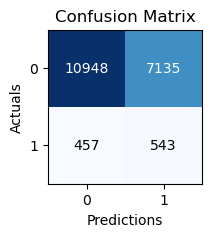

In [80]:
from mlxtend.plotting import plot_confusion_matrix

conf_matrix1=confusion_matrix(y_test1, y_pred1)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix1,figsize=(2, 2), cmap=plt.cm.Blues)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

#### Cross Validation 1

In [24]:
cross_val_scores1 = cross_val_score(clf1, X_train1, y_train1, cv=5,scoring='f1')
print(np.mean(cross_val_scores1))

0.6226637269978623


In [25]:
print(cross_val_scores1)

[0.61441815 0.62618878 0.62567152 0.6246471  0.62239309]


## Feature Selection

### Model 2: Based on Features Selected using Variance Threshold

#### Scaling the numericals (entire numerical dataset)

In [26]:
num_scaled=MinMaxScaler().fit_transform(numerical)
num_scaled=pd.DataFrame(num_scaled,columns=numerical.columns)

In [27]:
var_threshold= 0.02
sel = VarianceThreshold(threshold=(var_threshold))

sel= sel.fit(num_scaled)

In [28]:
var_list= list(sel.get_support()) #gives false for columns below the threshold

In [29]:
cols=[col[0] for col in zip(numerical.columns, var_list) if col[1] == False]
len(cols) # no of columns with low variance

236

In [30]:
# I want to keep columns with low variance that have correlation with the target > 0.1

corr=[]
for col in cols:
    if abs(num_scaled[col].corr(y_class)) >= 0.1:
        corr.append(col)
corr #  empty list means no columns have any good correaltion with the target

[]

In [31]:
#dropping columns with low variance from original numerical data (unscaled)

selected_cols=[col[0] for col in zip(numerical.columns, var_list) if col[1] == True]
num_data=pd.DataFrame(sel.transform(numerical),columns=selected_cols)
num_data.shape

(95412, 79)

#### Checking correlation between the remaining columns with each other

In [32]:
corr_matrix=num_data.corr()
corr_matrix.shape

(79, 79)

In [33]:
#finding columns that are highly correlated with each other

def high_corr(matrix):
    highly_corr=pd.DataFrame()
    
    for col in matrix.columns:
        correlated_cols = matrix[(abs(matrix[col]) >= 0.9)].index   
        correlated_pairs = pd.DataFrame({'column1': col, 'column2': correlated_cols})  
        highly_corr = pd.concat([highly_corr, correlated_pairs], ignore_index=True)
    highly_corr = highly_corr[highly_corr['column1'] < highly_corr['column2']]    
    return highly_corr

In [34]:
corr_df=high_corr(corr_matrix)
corr_df
# highly correlated columns

,column1,column2
13,DW1,DW2
17,DW4,DW5
18,DW4,DW6
21,DW5,DW6
22,DW5,HUPA2
23,DW5,HUPA6
27,DW6,HUPA2
28,DW6,HUPA6
30,HV1,HV2
31,HV1,HVP1


In [35]:
#checking if these columns have any good correlation wuth target
corr_w_y=[]

for index, row in corr_df.iterrows():
    col1, col2 = row['column1'], row['column2']
    if abs(numerical[col1].corr(y_class))>0.1:
        corr_w_y.append(col1)
    if abs(numerical[col2].corr(y_class))>0.1:
        corr_w_y.append(col2)
corr_w_y=list(set(corr_w_y))
corr_w_y #empty list means no good correlation

[]

In [36]:
#need drop columns with high correlation
drop_list= list(corr_df['column2'].unique())
num_data=num_data.drop(drop_list,axis=1)

In [37]:
num_data.head()

,AGE,INCOME,WEALTH1,VIETVETS,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,ETH2,HHN3,DW1,DW4,HV1,HV3,HU1,HU5,HHD2,ETHC2,HVP3,HVP5,HUR2,HUPA3,RP3,RP4,MSA,ADI,IC6,HHAS3,MC1,MC2,PEC2,TPE13,LFC2,LFC6,LFC7,LFC8,LFC9,VC1,VC3,POBC2,LSC1,VOC2,HC2,HC4,HC5,HC6,HC7,HC11,HC13,HC17,HC19,MHUC1,MHUC2,CARDPROM,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,60.000000,5.0,9.0,34.0,18.0,5.0,0.0,35.0,65.0,92.0,1.0,49.0,97.0,2.0,479.0,3.0,86.0,7.0,80.0,50.0,13.0,47.0,61.0,0.0,17.0,73.0,0.0,177.0,13.0,51.0,46.0,54.0,13.0,45.0,64.0,62.0,53.0,99.0,0.0,34.0,18.0,74.0,88.0,77.0,31.0,14.0,14.0,31.0,54.0,90.0,10.0,33.0,40.0,6.0,2.0,27.0,95515.0,0.0,4.0,39.0
1,46.000000,6.0,9.0,55.0,11.0,9.0,99.0,0.0,0.0,67.0,0.0,75.0,99.0,0.0,5468.0,12.0,96.0,9.0,94.0,44.0,98.0,99.0,83.0,0.0,91.0,94.0,4480.0,13.0,2.0,66.0,56.0,44.0,2.0,71.0,83.0,64.0,57.0,99.0,99.0,55.0,11.0,39.0,50.0,92.0,10.0,26.0,56.0,97.0,99.0,96.0,4.0,99.0,99.0,20.0,4.0,12.0,148535.0,0.0,2.0,1.0
2,61.611649,3.0,1.0,29.0,33.0,1.0,0.0,2.0,98.0,96.0,2.0,44.0,69.0,6.0,497.0,2.0,78.0,18.0,76.0,60.0,6.0,50.0,36.0,24.0,9.0,44.0,0.0,281.0,32.0,31.0,38.0,62.0,21.0,61.0,73.0,78.0,62.0,82.0,99.0,28.0,32.0,84.0,96.0,65.0,22.0,12.0,23.0,50.0,69.0,0.0,35.0,22.0,17.0,9.0,2.0,26.0,15078.0,1.0,4.0,60.0
3,70.000000,1.0,4.0,14.0,31.0,0.0,0.0,8.0,92.0,61.0,0.0,50.0,85.0,4.0,1000.0,2.0,48.0,6.0,73.0,36.0,50.0,92.0,42.0,9.0,17.0,34.0,9340.0,67.0,27.0,26.0,46.0,54.0,17.0,43.0,81.0,33.0,31.0,0.0,99.0,14.0,31.0,67.0,56.0,43.0,38.0,10.0,19.0,39.0,45.0,45.0,17.0,23.0,22.0,16.0,2.0,27.0,172556.0,1.0,4.0,41.0
4,78.000000,3.0,2.0,9.0,53.0,9.0,99.0,0.0,0.0,2.0,98.0,57.0,99.0,0.0,576.0,4.0,90.0,0.0,82.0,1.0,2.0,67.0,45.0,0.0,74.0,83.0,5000.0,127.0,24.0,11.0,20.0,80.0,1.0,76.0,73.0,80.0,31.0,81.0,99.0,9.0,53.0,65.0,99.0,45.0,34.0,1.0,3.0,6.0,33.0,9.0,72.0,99.0,21.0,6.0,2.0,43.0,7112.0,1.0,2.0,26.0


#### New 'X' with selected features 

In [38]:
#joining the numerical and categorical data

X2=pd.concat([num_data,categorical],axis=1)

#### X, y split and transforming numerical and categorical

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X2, y_class, test_size=0.2, random_state=0)

X_train_num   = X_train.select_dtypes(np.number)
X_test_num    = X_test.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object) 
X_test_cat  = X_test.select_dtypes(object) 

#### Scaling the numerical

In [40]:
transformer2 = MinMaxScaler().fit(X_train_num)
scaled_train = transformer2.transform(X_train_num)
X_train_scaled = pd.DataFrame(scaled_train, columns=X_train_num.columns)

scaled_test  = transformer2.transform(X_test_num)
X_test_scaled  = pd.DataFrame(scaled_test, columns=X_train_num.columns)

#### Encoding the categorical

In [41]:
encoder2 = OneHotEncoder(drop='first').fit(X_train_cat)
encoded_cat_train = encoder2.transform(X_train_cat).toarray()
X_train_encoded = pd.DataFrame(encoded_cat_train, columns=encoder2.get_feature_names_out())

encoded_cat_test = encoder2.transform(X_test_cat).toarray()
X_test_encoded = pd.DataFrame(encoded_cat_test, columns=encoder2.get_feature_names_out())

In [42]:
X_train=pd.concat([X_train_scaled, X_train_encoded],axis=1)
X_test=pd.concat([X_test_scaled,X_test_encoded],axis=1)

#### Need to deal with imbalance again

In [43]:
trainset2=pd.concat([X_train,y_train.reset_index(drop=True)],axis=1)

In [44]:
trainset2['TARGET_B'].value_counts()

0    72486
1     3843
Name: TARGET_B, dtype: int64

In [45]:
category_0 = trainset2[trainset2['TARGET_B']==0]
print(category_0.shape)

category_1_upsampled = trainset2[trainset2['TARGET_B']== 1 ].sample(len(trainset2[trainset2['TARGET_B']==0]),replace=True)
print(category_1_upsampled.shape)

(72486, 152)
(72486, 152)


In [46]:
trainset_upsampled2= pd.concat([category_0, category_1_upsampled], axis = 0) 
trainset_upsampled2 = trainset_upsampled2.sample(frac=1) #randomize the rows

In [47]:
X_train2 = trainset_upsampled2.drop(['TARGET_B'], axis=1)
y_train2 = trainset_upsampled2['TARGET_B']

In [48]:
X_test2= X_test.copy()
y_test2=y_test.copy()

In [49]:
# again assigning new variables for the model

#### Random Forest Classifier 2

In [50]:
clf2 = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             #max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf2.fit(X_train2, y_train2)
print(clf2.score(X_train2, y_train2))
print(clf2.score(X_test2, y_test2))

y_pred2 = clf2.predict(X_test2)
display(y_test2.value_counts())

0.6241412134757056
0.6039406801865534


0    18083
1     1000
Name: TARGET_B, dtype: int64

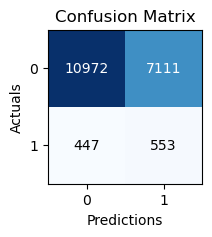

In [81]:
conf_matrix2=confusion_matrix(y_test2, y_pred2)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix2,figsize=(2, 2), cmap=plt.cm.Blues)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

In [52]:
#no of actual donors predicted as non-donors
#avg.donation=15

434*15

6510

In [53]:
#no .of non_donors predicted as donors
#cost per post=0.68

7323*(.68)

4979.64

- depending on if we want get more donation, we should reduce false negatives i.e. (441) by recall
- if we want to reduce money spent on post to non-donors, we should reduce false positives i.e (7364) by precision
- here we can see that both have almost same impact, so we can try to improve overall results by using 'f1'

#### Cross Validation 2

In [54]:
cross_val_scores2 = cross_val_score(clf2, X_train2, y_train2, cv=5,scoring='f1')
print(np.mean(cross_val_scores2))

0.6249613009857374


In [55]:
print(cross_val_scores2)

[0.63234452 0.62618999 0.61690227 0.61957612 0.62979361]


Features selection using variance threshold doesnt improve the model a lot

### Model 3: Based on the features selected using KBest after variance threshold

In [56]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [57]:
kbest_model = SelectKBest(chi2, k=25).fit(num_data, y_class)
df= pd.DataFrame(data = kbest_model.scores_, columns = ['score'])
df['column']=num_data.columns
print(df.sort_values(by = ['score'], ascending = False).head(25))

            score    column
56  527716.426176  CONTROLN
14   49855.611718       HV1
26   26891.429352       MSA
20    2132.962948      HVP3
10    1290.383905      ETH2
27     683.086698       ADI
24     556.639988       RP3
21     548.985073      HVP5
55     401.958866  CARDPROM
58     300.581935    RFA_2F
59     285.809600  CLUSTER2
29     264.905707     HHAS3
47     248.312216       HC6
41     244.762058     POBC2
28     192.744194       IC6
17     190.704169       HU5
46     169.736570       HC5
48     165.466647       HC7
25     149.506795       RP4
9      148.794974      ETH1
8      143.354382   POP90C3
6      127.375035   POP90C1
45     107.753419       HC4
40     100.196484       VC3
43      81.046390      VOC2


In [58]:
top_cols= list(df.sort_values(by = ['score'], ascending = False)['column'].head(25))
#gives the list of top 25 column names

In [59]:
#using the list of names to create a new dataframe with the top columns only
top_ft=numerical[top_cols]
top_ft.head()

,CONTROLN,HV1,MSA,HVP3,ETH2,ADI,RP3,HVP5,CARDPROM,RFA_2F,CLUSTER2,HHAS3,HC6,POBC2,IC6,HU5,HC5,HC7,RP4,ETH1,POP90C3,POP90C1,HC4,VC3,VOC2
0,95515,479,0.0,13,1,177.0,17,47,27,4,39,51,31,74,13,7,14,54,73,92,65,0,14,18,77
1,148535,5468,4480.0,98,0,13.0,91,99,12,2,1,66,97,39,2,9,56,99,94,67,0,99,26,11,92
2,15078,497,0.0,6,2,281.0,9,50,26,4,60,31,50,84,32,18,23,69,44,96,98,0,12,32,65
3,172556,1000,9340.0,50,0,67.0,17,92,27,4,41,26,39,67,27,6,19,45,34,61,92,0,10,31,43
4,7112,576,5000.0,2,98,127.0,74,67,43,2,26,11,6,65,24,0,3,33,83,2,0,99,1,53,45


In [60]:
corr_matrix=top_ft.corr()
corr_matrix.shape

(25, 25)

In [61]:
high_corr(corr_matrix)
# if empty, then there are no highly correlated columns with each other

,column1,column2


In [62]:
X3=pd.concat([top_ft,categorical],axis=1)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=0)

X_train_num   = X_train.select_dtypes(np.number)
X_test_num    = X_test.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object) 
X_test_cat  = X_test.select_dtypes(object) 

In [64]:
transformer3 = MinMaxScaler().fit(X_train_num)
scaled_train = transformer3.transform(X_train_num)
X_train_scaled = pd.DataFrame(scaled_train, columns=X_train_num.columns)

scaled_test  = transformer3.transform(X_test_num)
X_test_scaled  = pd.DataFrame(scaled_test, columns=X_train_num.columns)

In [65]:
encoder3 = OneHotEncoder(drop='first').fit(X_train_cat)
encoded_cat_train = encoder3.transform(X_train_cat).toarray()
X_train_encoded = pd.DataFrame(encoded_cat_train, columns=encoder3.get_feature_names_out())

encoded_cat_test = encoder3.transform(X_test_cat).toarray()
X_test_encoded = pd.DataFrame(encoded_cat_test, columns=encoder3.get_feature_names_out())

In [66]:
X_train=pd.concat([X_train_scaled, X_train_encoded],axis=1)
X_test=pd.concat([X_test_scaled,X_test_encoded],axis=1)

In [67]:
trainset3=pd.concat([X_train,y_train.reset_index(drop=True)],axis=1)

In [68]:
trainset3['TARGET_B'].value_counts()

0    72486
1     3843
Name: TARGET_B, dtype: int64

In [69]:
category_0 = trainset3[trainset3['TARGET_B']==0]
print(category_0.shape)

category_1_upsampled = trainset3[trainset3['TARGET_B']== 1 ].sample(len(trainset3[trainset3['TARGET_B']==0]),replace=True)
print(category_1_upsampled.shape)

(72486, 407)
(72486, 407)


In [70]:
trainset_upsampled3= pd.concat([category_0, category_1_upsampled], axis = 0) 
trainset_upsampled3 = trainset_upsampled3.sample(frac=1) #randomize the rows

In [71]:
X_train3 = trainset_upsampled3.drop(['TARGET_B'], axis=1)
y_train3 = trainset_upsampled3['TARGET_B']

In [72]:
X_test3=X_test.copy()
y_test3=y_test.copy()

In [73]:
clf3 = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             #max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf3.fit(X_train3, y_train3)
print(clf3.score(X_train3, y_train3))
print(clf3.score(X_test3, y_test3))

y_pred3 = clf3.predict(X_test3)
display(y_test3.value_counts())

0.6222856827525315
0.6093381543782425


0    18083
1     1000
Name: TARGET_B, dtype: int64

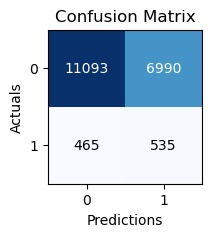

In [82]:
conf_matrix3=confusion_matrix(y_test3, y_pred3)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix3,figsize=(2, 2), cmap=plt.cm.Blues)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

In [77]:
cross_val_scores3 = cross_val_score(clf3, X_train3, y_train3, cv=5,scoring='f1')
print(np.mean(cross_val_scores3))

0.6196114174077909


In [78]:
print(cross_val_scores3)

[0.62256039 0.62119201 0.612696   0.62451833 0.61709036]


## Summary

### Likely returns if we were to send mail for donations based on our model

In [79]:
#let's see the avg donations
round(targets[targets['TARGET_B']==1]['TARGET_D'].mean(),2)

15.62

- Let's assume the cost per mail is $0.68

In [99]:
display('Confusion Matrix 1', conf_matrix1)

money_spent= 0.68*(conf_matrix1[0][1] + conf_matrix1[1][1]) # money spent on mail to all predicted as donors
missed_donations= (15.62-0.68) * conf_matrix1[1][0] #actual donors but predicted as non donors
probable_donations= 15.62 * conf_matrix1[1][1] #correctly predicted donors
profit= probable_donations - money_spent

print('Probable Donations: ', round(probable_donations,2))
print('Money spent: ', round(money_spent,2))
print('Missed donations: ', round(missed_donations,2))
print('Profit: ', round(profit,2))

'Confusion Matrix 1'

array([[10948,  7135],
       [  457,   543]], dtype=int64)

Probable Donations:  8481.66
Money spent:  5221.04
Missed donations:  6827.58
Profit:  3260.62


In [100]:
display('Confusion Matrix 2', conf_matrix2)

money_spent= 0.68*(conf_matrix2[0][1] + conf_matrix2[1][1]) # money spent on mail to all predicted as donors
missed_donations= (15.62-0.68) * conf_matrix2[1][0] #actual donors but predicted as non donors
probable_donations= 15.62 * conf_matrix2[1][1] #correctly predicted donors
profit= probable_donations - money_spent

print('Probable Donations: ', round(probable_donations,2))
print('Money spent: ', round(money_spent,2))
print('Missed donations: ', round(missed_donations,2))
print('Profit: ', round(profit,2))

'Confusion Matrix 2'

array([[10972,  7111],
       [  447,   553]], dtype=int64)

Probable Donations:  8637.86
Money spent:  5211.52
Missed donations:  6678.18
Profit:  3426.34


In [101]:
display('Confusion Matrix 3', conf_matrix3)

money_spent= 0.68*(conf_matrix3[0][1] + conf_matrix3[1][1]) # money spent on mail to all predicted as donors
missed_donations= (15.62-0.68) * conf_matrix3[1][0] #actual donors but predicted as non donors
probable_donations= 15.62 * conf_matrix3[1][1] #correctly predicted donors
profit= probable_donations - money_spent

print('Probable Donations: ', round(probable_donations,2))
print('Money spent: ', round(money_spent,2))
print('Missed donations: ', round(missed_donations,2))
print('Profit: ', round(profit,2))

'Confusion Matrix 3'

array([[11093,  6990],
       [  465,   535]], dtype=int64)

Probable Donations:  8356.7
Money spent:  5117.0
Missed donations:  6947.1
Profit:  3239.7


In [92]:
# assuming we send mail to everyone; except to the correctly predicted non donors
# assumption1: donors predicted as non donors will donate as per the average
# assumption2: non donors predicted as donors will not donate 

# using predictions from model 2

display('Confusion Matrix 2', conf_matrix2)

possible_donations= (15.62-0.68)*(conf_matrix2[1][0]+ conf_matrix2[1][1])
spent_extra= 0.68 * conf_matrix2[0][1]

profit= possible_donations-spent_extra

print('Extra money spent: ', round(spent_extra,2))
print('Gross Donations: ', round(possible_donations,2))
print('Profit: ', round(profit,2))

'Confusion Matrix 2'

array([[10972,  7111],
       [  447,   553]], dtype=int64)

Extra money spent:  4835.48
Gross Donations:  14940.0
Profit:  10104.52


### Now we will use the model to make predictions on our entire dataset

- Features selection using variance threshold has overall higher average cross-val score as well as scores are almost consistent.
- Therefore, that model will be use on the entire dataset to make new predictions

In [119]:
# using only columns that we used for the model- variance threshold
X2.head()

,AGE,INCOME,WEALTH1,VIETVETS,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,ETH2,HHN3,DW1,DW4,HV1,HV3,HU1,HU5,HHD2,ETHC2,HVP3,HVP5,HUR2,HUPA3,RP3,RP4,MSA,ADI,IC6,HHAS3,MC1,MC2,PEC2,TPE13,LFC2,LFC6,LFC7,LFC8,LFC9,VC1,VC3,POBC2,LSC1,VOC2,HC2,HC4,HC5,HC6,HC7,HC11,HC13,HC17,HC19,MHUC1,MHUC2,CARDPROM,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,CLUSTER,AGEFLAG,HOMEOWNR,GENDER,DATASRCE,SOLIH,VETERANS,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B
0,60.000000,5.0,9.0,34.0,18.0,5.0,0.0,35.0,65.0,92.0,1.0,49.0,97.0,2.0,479.0,3.0,86.0,7.0,80.0,50.0,13.0,47.0,61.0,0.0,17.0,73.0,0.0,177.0,13.0,51.0,46.0,54.0,13.0,45.0,64.0,62.0,53.0,99.0,0.0,34.0,18.0,74.0,88.0,77.0,31.0,14.0,14.0,31.0,54.0,90.0,10.0,33.0,40.0,6.0,2.0,27.0,95515.0,0.0,4.0,39.0,IL,36,U,U,F,0,4,N,L,E,C,T,2
1,46.000000,6.0,9.0,55.0,11.0,9.0,99.0,0.0,0.0,67.0,0.0,75.0,99.0,0.0,5468.0,12.0,96.0,9.0,94.0,44.0,98.0,99.0,83.0,0.0,91.0,94.0,4480.0,13.0,2.0,66.0,56.0,44.0,2.0,71.0,83.0,64.0,57.0,99.0,99.0,55.0,11.0,39.0,50.0,92.0,10.0,26.0,56.0,97.0,99.0,96.0,4.0,99.0,99.0,20.0,4.0,12.0,148535.0,0.0,2.0,1.0,CA,14,E,H,M,3,4,N,L,G,A,S,1
2,61.611649,3.0,1.0,29.0,33.0,1.0,0.0,2.0,98.0,96.0,2.0,44.0,69.0,6.0,497.0,2.0,78.0,18.0,76.0,60.0,6.0,50.0,36.0,24.0,9.0,44.0,0.0,281.0,32.0,31.0,38.0,62.0,21.0,61.0,73.0,78.0,62.0,82.0,99.0,28.0,32.0,84.0,96.0,65.0,22.0,12.0,23.0,50.0,69.0,0.0,35.0,22.0,17.0,9.0,2.0,26.0,15078.0,1.0,4.0,60.0,NC,43,U,U,M,3,4,N,L,E,C,R,2
3,70.000000,1.0,4.0,14.0,31.0,0.0,0.0,8.0,92.0,61.0,0.0,50.0,85.0,4.0,1000.0,2.0,48.0,6.0,73.0,36.0,50.0,92.0,42.0,9.0,17.0,34.0,9340.0,67.0,27.0,26.0,46.0,54.0,17.0,43.0,81.0,33.0,31.0,0.0,99.0,14.0,31.0,67.0,56.0,43.0,38.0,10.0,19.0,39.0,45.0,45.0,17.0,23.0,22.0,16.0,2.0,27.0,172556.0,1.0,4.0,41.0,CA,44,E,U,F,3,4,N,L,E,C,R,2
4,78.000000,3.0,2.0,9.0,53.0,9.0,99.0,0.0,0.0,2.0,98.0,57.0,99.0,0.0,576.0,4.0,90.0,0.0,82.0,1.0,2.0,67.0,45.0,0.0,74.0,83.0,5000.0,127.0,24.0,11.0,20.0,80.0,1.0,76.0,73.0,80.0,31.0,81.0,99.0,9.0,53.0,65.0,99.0,45.0,34.0,1.0,3.0,6.0,33.0,9.0,72.0,99.0,21.0,6.0,2.0,43.0,7112.0,1.0,2.0,26.0,FL,16,E,H,F,3,12,N,L,F,A,S,2


In [120]:
X2

,AGE,INCOME,WEALTH1,VIETVETS,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,ETH2,HHN3,DW1,DW4,HV1,HV3,HU1,HU5,HHD2,ETHC2,HVP3,HVP5,HUR2,HUPA3,RP3,RP4,MSA,ADI,IC6,HHAS3,MC1,MC2,PEC2,TPE13,LFC2,LFC6,LFC7,LFC8,LFC9,VC1,VC3,POBC2,LSC1,VOC2,HC2,HC4,HC5,HC6,HC7,HC11,HC13,HC17,HC19,MHUC1,MHUC2,CARDPROM,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,CLUSTER,AGEFLAG,HOMEOWNR,GENDER,DATASRCE,SOLIH,VETERANS,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B
0,60.000000,5.0,9.0,34.0,18.0,5.0,0.0,35.0,65.0,92.0,1.0,49.0,97.0,2.0,479.0,3.0,86.0,7.0,80.0,50.0,13.0,47.0,61.0,0.0,17.0,73.0,0.0,177.0,13.0,51.0,46.0,54.0,13.0,45.0,64.0,62.0,53.0,99.0,0.0,34.0,18.0,74.0,88.0,77.0,31.0,14.0,14.0,31.0,54.0,90.0,10.0,33.0,40.0,6.0,2.0,27.0,95515.0,0.0,4.0,39.0,IL,36,U,U,F,0,4,N,L,E,C,T,2
1,46.000000,6.0,9.0,55.0,11.0,9.0,99.0,0.0,0.0,67.0,0.0,75.0,99.0,0.0,5468.0,12.0,96.0,9.0,94.0,44.0,98.0,99.0,83.0,0.0,91.0,94.0,4480.0,13.0,2.0,66.0,56.0,44.0,2.0,71.0,83.0,64.0,57.0,99.0,99.0,55.0,11.0,39.0,50.0,92.0,10.0,26.0,56.0,97.0,99.0,96.0,4.0,99.0,99.0,20.0,4.0,12.0,148535.0,0.0,2.0,1.0,CA,14,E,H,M,3,4,N,L,G,A,S,1
2,61.611649,3.0,1.0,29.0,33.0,1.0,0.0,2.0,98.0,96.0,2.0,44.0,69.0,6.0,497.0,2.0,78.0,18.0,76.0,60.0,6.0,50.0,36.0,24.0,9.0,44.0,0.0,281.0,32.0,31.0,38.0,62.0,21.0,61.0,73.0,78.0,62.0,82.0,99.0,28.0,32.0,84.0,96.0,65.0,22.0,12.0,23.0,50.0,69.0,0.0,35.0,22.0,17.0,9.0,2.0,26.0,15078.0,1.0,4.0,60.0,NC,43,U,U,M,3,4,N,L,E,C,R,2
3,70.000000,1.0,4.0,14.0,31.0,0.0,0.0,8.0,92.0,61.0,0.0,50.0,85.0,4.0,1000.0,2.0,48.0,6.0,73.0,36.0,50.0,92.0,42.0,9.0,17.0,34.0,9340.0,67.0,27.0,26.0,46.0,54.0,17.0,43.0,81.0,33.0,31.0,0.0,99.0,14.0,31.0,67.0,56.0,43.0,38.0,10.0,19.0,39.0,45.0,45.0,17.0,23.0,22.0,16.0,2.0,27.0,172556.0,1.0,4.0,41.0,CA,44,E,U,F,3,4,N,L,E,C,R,2
4,78.000000,3.0,2.0,9.0,53.0,9.0,99.0,0.0,0.0,2.0,98.0,57.0,99.0,0.0,576.0,4.0,90.0,0.0,82.0,1.0,2.0,67.0,45.0,0.0,74.0,83.0,5000.0,127.0,24.0,11.0,20.0,80.0,1.0,76.0,73.0,80.0,31.0,81.0,99.0,9.0,53.0,65.0,99.0,45.0,34.0,1.0,3.0,6.0,33.0,9.0,72.0,99.0,21.0,6.0,2.0,43.0,7112.0,1.0,2.0,26.0,FL,16,E,H,F,3,12,N,L,F,A,S,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,61.611649,5.0,9.0,47.0,11.0,9.0,99.0,0.0,0.0,78.0,10.0,48.0,54.0,32.0,988.0,6.0,56.0,3.0,72.0,55.0,49.0,92.0,40.0,13.0,92.0,97.0,380.0,0.0,11.0,70.0,63.0,37.0,2.0,69.0,89.0,69.0,57.0,61.0,94.0,48.0,11.0,26.0,92.0,60.0,14.0,7.0,32.0,78.0,91.0,86.0,12.0,93.0,98.0,16.0,4.0,6.0,184568.0,0.0,1.0,12.0,other,27,U,U,M,0,4,N,L,G,C,C,2
95408,48.000000,7.0,9.0,43.0,19.0,9.0,96.0,0.0,4.0,91.0,3.0,70.0,89.0,1.0,1679.0,3.0,88.0,0.0,89.0,58.0,88.0,97.0,77.0,10.0,44.0,79.0,3360.0,201.0,8.0,61.0,83.0,17.0,3.0,61.0,88.0,48.0,43.0,99.0,0.0,43.0,19.0,51.0,94.0,84.0,7.0,55.0,90.0,94.0,94.0,82.0,16.0,69.0,67.0,18.0,5.0,4.0,122706.0,1.0,1.0,2.0,TX,24,E,H,M,3,4,N,L,F,A,C,1
95409,60.000000,5.0,9.0,46.0,20.0,9.0,99.0,0.0,0.0,82.0,14.0,44.0,96.0,2.0,376.0,4.0,66.0,10.0,64.0,49.0,0.0,9.0,45.0,0.0,78.0,91.0,4040.0,61.0,21.0,26.0,43.0,57.0,25.0,69.0,70.0,77.0,24.0,62.0,0.0,46.0,20.0,82.0,92.0,42.0,51.0,0.0,0.0,0.0,0.0,97.0,0.0,99.0,99.0,5.0,2.0,14.0,189641.0,1.0,3.0,34.0,MI,30,U,U,M,0,4,N,L,E,B,C,3
95410,58.000000,7.0,9.0,35.0,20.0,7.0,99.0,0.0,0.0,92.0,1.0,65.0,99.0,0.0,2421.0,11.0,88.0,0.0,85.0,56.0,99.0,99.0,90.0,0.0,90.0,91.0,8735.0,13.0,7.0,46.0,43.0,57.0,24.0,52.0,88.0,70.0,54.0,99.0,99.0,35.0,20.0,50.0,83.0,85.0,25.0,0.0,6.0,17.0,99.0,99.0,1.0,99.0,99.0,12.0,3.0,36.0,4693.0,1.0,4.0,11.0,CA,24,E,H,F,2,12,N,L,F,A,C,1


In [121]:
X_num=X2.select_dtypes(np.number)
X_cat=X2.select_dtypes(object)

In [122]:
#using the same transformer and encoder used during variance threshold process

X_num_scaled=pd.DataFrame(transformer2.transform(X_num),columns=X_num.columns)
X_cat_encoded= pd.DataFrame(encoder2.transform(X_cat).toarray(), columns=encoder2.get_feature_names_out())

X2_trans=pd.concat([X_num_scaled,X_cat_encoded],axis=1)

In [123]:
X2_trans

,AGE,INCOME,WEALTH1,VIETVETS,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,ETH2,HHN3,DW1,DW4,HV1,HV3,HU1,HU5,HHD2,ETHC2,HVP3,HVP5,HUR2,HUPA3,RP3,RP4,MSA,ADI,IC6,HHAS3,MC1,MC2,PEC2,TPE13,LFC2,LFC6,LFC7,LFC8,LFC9,VC1,VC3,POBC2,LSC1,VOC2,HC2,HC4,HC5,HC6,HC7,HC11,HC13,HC17,HC19,MHUC1,MHUC2,CARDPROM,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE_FL,STATE_GA,STATE_IL,STATE_IN,STATE_MI,STATE_MO,STATE_NC,STATE_TX,STATE_WA,STATE_WI,STATE_other,CLUSTER_10,CLUSTER_11,CLUSTER_12,CLUSTER_13,CLUSTER_14,CLUSTER_15,CLUSTER_16,CLUSTER_17,CLUSTER_18,CLUSTER_19,CLUSTER_2,CLUSTER_20,CLUSTER_21,CLUSTER_22,CLUSTER_23,CLUSTER_24,CLUSTER_25,CLUSTER_26,CLUSTER_27,CLUSTER_28,CLUSTER_29,CLUSTER_3,CLUSTER_30,CLUSTER_31,CLUSTER_32,CLUSTER_33,CLUSTER_34,CLUSTER_35,CLUSTER_36,CLUSTER_37,CLUSTER_38,CLUSTER_39,CLUSTER_4,CLUSTER_40,CLUSTER_41,CLUSTER_42,CLUSTER_43,CLUSTER_44,CLUSTER_45,CLUSTER_46,CLUSTER_47,CLUSTER_48,CLUSTER_49,CLUSTER_5,CLUSTER_50,CLUSTER_51,CLUSTER_52,CLUSTER_53,CLUSTER_6,CLUSTER_7,CLUSTER_8,CLUSTER_9,AGEFLAG_I,AGEFLAG_U,HOMEOWNR_U,GENDER_M,GENDER_other,DATASRCE_1,DATASRCE_2,DATASRCE_3,SOLIH_1,SOLIH_12,SOLIH_2,SOLIH_3,SOLIH_4,SOLIH_6,VETERANS_Y,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U,DOMAIN_B_2,DOMAIN_B_3,DOMAIN_B_4
0,0.608247,0.666667,1.000000,0.343434,0.181818,0.555556,0.000000,0.353535,0.656566,0.929293,0.010101,0.494949,0.979798,0.020202,0.079833,0.230769,0.868687,0.070707,0.808081,0.505051,0.131313,0.474747,0.616162,0.000000,0.171717,0.737374,0.000000,0.271889,0.131313,0.515152,0.464646,0.545455,0.131313,0.454545,0.646465,0.626263,0.535354,1.000000,0.000000,0.343434,0.181818,0.747475,0.888889,0.777778,0.596154,0.141414,0.141414,0.313131,0.545455,0.909091,0.101010,0.333333,0.404040,0.285714,0.4,0.433333,0.498045,0.0,1.000000,0.622951,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.463918,0.833333,1.000000,0.555556,0.111111,1.000000,1.000000,0.000000,0.000000,0.676768,0.000000,0.757576,1.000000,0.000000,0.911333,0.923077,0.969697,0.090909,0.949495,0.444444,0.989899,1.000000,0.838384,0.000000,0.919192,0.949495,0.478632,0.019969,0.020202,0.666667,0.565657,0.444444,0.020202,0.717172,0.838384,0.646465,0.575758,1.000000,1.000000,0.555556,0.111111,0.393939,0.505051,0.929293,0.192308,0.262626,0.565657,0.979798,1.000000,0.969697,0.040404,1.000000,1.000000,0.952381,0.8,0.183333,0.774510,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.624862,0.333333,0.111111,0.292929,0.333333,0.111111,0.000000,0.020202,0.989899,0.969697,0.020202,0.444444,0.696970,0.060606,0.082833,0.153846,0.787879,0.181818,0.767677,0.606061,0.060606,0.505051,0.363636,0.242424,0.090909,0.444444,0.000000,0.431644,0.323232,0.313131,0.383838,0.626263,0.212121,0.616162,0.737374,0.787879,0.626263,0.828283,1.000000,0.282828,0.323232,0.848485,0.969697,0.656566,0.423077,0.121212,0.232323,0.505051,0.696970,0.000000,0.353535,0.222222,0.171717,0.428571,0.4,0.416667,0.078617,1.0,1.000000,0.967213,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.711340,0.000000,0.444444,0.14

In [125]:
final_pred=clf2.predict(X2_trans)
final_pred= pd.DataFrame(final_pred,columns=['TARGET_B_pred'])
final_pred.head()

,TARGET_B_pred
0,1
1,0
2,1
3,1
4,0


In [128]:
prediction_df=pd.concat([targets,final_pred],axis=1)
prediction_df.head()
prediction_df.to_csv('./files_for_lab/prediction_df.csv',index=False)

## Regression

In [ ]:
# want the same features that were used for classifcation model
#'num_data' has numerical data without low variance columns

donated=pd.concat([top_ft,categorical,targets],axis=1)
donated.head()

In [ ]:
# Only look at people who have donated (Target_B = 1) 
donated= donated[donated['TARGET_B']==1]
donated.shape

In [ ]:
X=donated.drop(['TARGET_B','TARGET_D'],axis=1)
y_regr=donated['TARGET_D']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_regr, test_size=0.2, random_state=0)

X_train_num   = X_train.select_dtypes(np.number)
X_test_num    = X_test.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object) 
X_test_cat  = X_test.select_dtypes(object) 

In [ ]:
transformer = MinMaxScaler().fit(X_train_num)
scaled_train = transformer.transform(X_train_num)
X_train_scaled = pd.DataFrame(scaled_train, columns=X_train_num.columns)

scaled_test  = transformer.transform(X_test_num)
X_test_scaled  = pd.DataFrame(scaled_test, columns=X_train_num.columns)

In [ ]:
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
encoded_cat_train = encoder.transform(X_train_cat).toarray()
X_train_encoded = pd.DataFrame(encoded_cat_train, columns=encoder.get_feature_names_out())

encoded_cat_test = encoder.transform(X_test_cat).toarray()
X_test_encoded = pd.DataFrame(encoded_cat_test, columns=encoder.get_feature_names_out())

In [ ]:
X_train=pd.concat([X_train_scaled, X_train_encoded],axis=1)
X_test=pd.concat([X_test_scaled,X_test_encoded],axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model_list=[LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor(max_depth=2),RandomForestRegressor(max_depth=3)]

In [ ]:
def run_model(models, X_tr, y_tr,X_te, y_te):
    for model in models:
        model.fit(X_tr, y_tr)
        print(f"{model.__class__.__name__}: Train -> {model.score(X_tr, y_tr)}, Test -> {model.score(X_te, y_te)}")

In [ ]:
run_model(model_list,X_train,y_train,X_test,y_test)

In [ ]:
max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = RandomForestRegressor(max_depth=depth, random_state=0)
    model.fit(X_train, y_train)
    test.append(model.score(X_test,y_test))
    train.append(model.score(X_train,y_train))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth-1")
plt.legend()